In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import librosa
import librosa.display
from torch.utils.data import sampler
import torch.optim as optim
import json
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from torchinfo import summary
from tqdm import tqdm
import os
import shutil
import scipy.signal as signal


In [13]:
class NLMS():
    #initialize
    def __init__(self,mu,taps):
        self.mu=mu
        self.N=taps
        self.e=0
        self.w=np.zeros((taps,1))
        self.xd=np.zeros((taps,1))

    #updates the filter sample by sample and updates weights sample by sample
    def run(self,x,d):
        N=self.N
        #udpate delay line 
        self.xd[0]=x
        #compute filter output
        y = np.dot(self.w.T,self.xd)
        #compute input energy
        pw=np.linalg.norm(self.xd)
        pw=pw*pw
        #pw=pw*pw
        #calculate error
        e = d - y
        self.e=e

        #normalize by input energy
        e= e/(pw+0.001)
        #compute gradients
        Fw=self.mu*np.multiply(self.xd,e)
        
        Fw=Fw.reshape(Fw.shape[0],-1)
        #weight update
        self.w = self.w + Fw
    
        #filtered output post update
        y = np.dot(self.w.T,self.xd)
        #shift delay line
        self.xd[1:]=self.xd[:-1]
 
        #return current output sample, current error sample and current weights
        return (y,self.e,self.w)

In [9]:
# dir="../dataset/AEC-Challenge/datasets/synthetic/residual_echo"
# shutil.rmtree(dir)

Run a test file using the model to process and remove the echo

In [11]:
dir="../dataset/AEC-Challenge/datasets/synthetic/residual/"
os.mkdir(dir)
taps=1024
nlms=NLMS(0.1,taps)
for i in tqdm(range(0,720)):
    file_indx=i
    mic_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/nearend_mic_signal/nearend_mic_fileid_"+str(file_indx)+".wav",sr=8000)
    fend_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/farend_speech/farend_speech_fileid_"+str(file_indx)+".wav",sr=8000)
    nend_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/nearend_speech/nearend_speech_fileid_"+str(file_indx)+".wav",sr=8000)
    echo_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/echo_signal/echo_fileid_"+str(file_indx)+".wav",sr=8000)
    lpf=[1,-0.99]
    pecho=signal.lfilter(lpf,[1],mic_sig)
    pfend=signal.lfilter(lpf,[1],fend_sig)
    slice=len(fend_sig)
    mic_sig=np.concatenate((mic_sig,mic_sig,mic_sig,mic_sig,mic_sig,mic_sig),axis=0)
    pfend=np.concatenate((pfend,pfend,pfend,pfend,pfend,pfend),axis=0)
    nend_sig=np.concatenate((nend_sig,nend_sig,nend_sig,nend_sig,nend_sig,nend_sig),axis=0)
    pecho=np.concatenate((pecho,pecho,pecho,pecho,pecho,pecho),axis=0)
    fend_sig=np.concatenate((fend_sig,fend_sig,fend_sig,fend_sig,fend_sig,fend_sig),axis=0)
    echo_sig=np.concatenate((echo_sig,echo_sig,echo_sig,echo_sig,echo_sig,echo_sig),axis=0)
    w=np.zeros((taps,1))
    out=np.zeros_like(fend_sig)
    e=np.zeros_like(fend_sig)
    for i in range(0,len(fend_sig)):
        (out[i],e[i],w)=nlms.run(pfend[i],pecho[i])
    w=np.squeeze(w,axis=1)
    out=signal.lfilter(w,[1],fend_sig)
    e=mic_sig-out
    wav.write(dir+"residual_fileid_"+str(file_indx)+".wav", 8000, e[-slice*2:-slice])

100%|██████████| 720/720 [1:37:36<00:00,  8.13s/it]


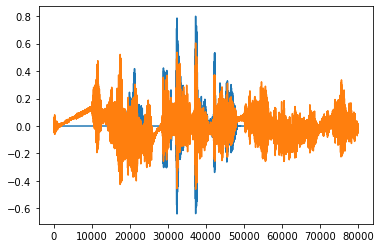

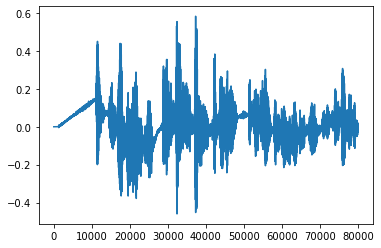

In [12]:
plt.figure()
plt.plot(nend_sig[-slice*2:-slice])
plt.plot(e[-slice*2:-slice])
plt.figure()
plt.plot(mic_sig[-slice*2:-slice])

In [18]:
dir="../dataset/AEC-Challenge/datasets/synthetic/residualecho/"
shutil.rmtree(dir)
os.mkdir(dir)
taps=1024
nlms=NLMS(0.5,taps)
for i in tqdm(range(0,720)):
    file_indx=i
    mic_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/nearend_mic_signal/nearend_mic_fileid_"+str(file_indx)+".wav",sr=8000)
    fend_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/farend_speech/farend_speech_fileid_"+str(file_indx)+".wav",sr=8000)
    nend_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/nearend_speech/nearend_speech_fileid_"+str(file_indx)+".wav",sr=8000)
    echo_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/echo_signal/echo_fileid_"+str(file_indx)+".wav",sr=8000)
    lpf=[1,-0.99]
    pecho=signal.lfilter(lpf,[1],echo_sig)
    pfend=signal.lfilter(lpf,[1],fend_sig)
    slice=len(fend_sig)
    mic_sig=np.concatenate((mic_sig,mic_sig,mic_sig,mic_sig,mic_sig,mic_sig),axis=0)
    pfend=np.concatenate((pfend,pfend,pfend,pfend,pfend,pfend),axis=0)
    nend_sig=np.concatenate((nend_sig,nend_sig,nend_sig,nend_sig,nend_sig,nend_sig),axis=0)
    pecho=np.concatenate((pecho,pecho,pecho,pecho,pecho,pecho),axis=0)
    fend_sig=np.concatenate((fend_sig,fend_sig,fend_sig,fend_sig,fend_sig,fend_sig),axis=0)
    echo_sig=np.concatenate((echo_sig,echo_sig,echo_sig,echo_sig,echo_sig,echo_sig),axis=0)
    w=np.zeros((taps,1))
    out=np.zeros_like(fend_sig)
    e=np.zeros_like(fend_sig)
    for i in range(0,len(fend_sig)):
        (out[i],e[i],w)=nlms.run(pfend[i],pecho[i])
    w=np.squeeze(w,axis=1)
    out=signal.lfilter(w,[1],fend_sig)
    e=echo_sig-out
    wav.write(dir+"residualecho_fileid_"+str(file_indx)+".wav", 8000, e[-slice*2:-slice])

100%|██████████| 720/720 [1:37:40<00:00,  8.14s/it]


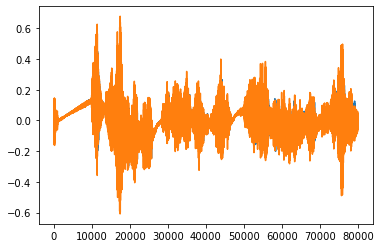

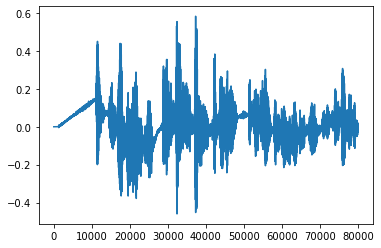

In [19]:
plt.figure()
plt.plot(echo_sig[-slice*2:-slice])
plt.plot(e[-slice*2:-slice])
plt.figure()
plt.plot(mic_sig[-slice*2:-slice])